In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import random, os, collections, io
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# import matplotlib as pyplot

In [2]:
def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random()
    is_root = True
    for (dirname, subdirs, filenames) in tf.io.gfile.walk('/home/kalafreaky/code/data/'):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            is_root = False
        # The sub directories give us the image files for training.
        else:
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            label = dirname.split('/')[-1] # '/' for linux and '\\' for windows
            label_class = label_to_class[label]
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            num_train = int(len(filenames) * 0.715)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])
    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for x in train_examples:
        tmp = Image.open(x[0]).resize((558, 1005)) # Original: (1116, 2011)
        data = np.asarray(tmp)
        x_train.append(data)
#         x_train.append(x[0])
        tmp = np.asarray([x[1]])
        y_train.append(tmp)
    for y in test_examples:
        tmp = Image.open(y[0]).resize((558, 1005))
        data = np.asarray(tmp)
        x_test.append(data)
#         x_test.append(y[0])
        tmp = np.asarray([y[1]])
        y_test.append(tmp)
    return x_train, y_train, x_test, y_test, classes

In [3]:
TRAIN_SAMPLE, TRAIN_LABEL, TEST_SAMPLE, TEST_LABEL, CLASSES = make_train_and_test_sets()

So here is the thing... The only conclusion I can come to is that the the images vary in size and that is causing the fit method to fail.

In [12]:
TRAIN_SAMPLE = np.array(TRAIN_SAMPLE)
TEST_SAMPLE = np.array(TRAIN_SAMPLE)
TRAIN_LABEL = np.array(TRAIN_LABEL)
TEST_LABEL = np.array(TEST_LABEL)
print(len(TRAIN_SAMPLE))
print(len(TRAIN_LABEL))
print(len(TEST_SAMPLE))
print(len(TEST_LABEL))

70
70
70
29


Here is where we create the model that we are going to use. Keras is a lot more straightforward than old tensorflow.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (32, 32), activation='relu', input_shape=(1005, 558, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (32, 32), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (32, 32), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
# model.summary()

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

So here is the thing that gets weird. I can't get the model to train using the images and labels from our set. I decided to try and use a data set that is supplied in the tensorflow package. It seems to work fine.

Training the model

In [7]:
for i in range(14):
    a = i * 5
    print(TRAIN_SAMPLE[(a):(a+5)].shape)
    print(TRAIN_LABEL[(a):(a+5)].shape)
    history = model.fit(TRAIN_SAMPLE[(a):(a+5)], TRAIN_LABEL[(a):(a+5)])#, epochs=1)
    print('fit complete')

(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 1058s 1058s/step - loss: 4.6544 - accuracy: 0.4000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 1017s 1017s/step - loss: 10010178.0000 - accuracy: 0.8000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 992s 992s/step - loss: 91739.4141 - accuracy: 0.6000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 1002s 1002s/step - loss: 501471.3125 - accuracy: 0.2000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 998s 998s/step - loss: 0.6836 - accuracy: 0.6000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 960s 960s/step - loss: 0.8745 - accuracy: 0.2000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 1001s 1001s/step - loss: 0.8668 - accuracy: 0.4000
fit complete
(5, 1005, 558, 3)
(5, 1)
1/1 [==============================] - 994s 994s/step - loss: 0.8836 

KeyError: 'val_accuracy'

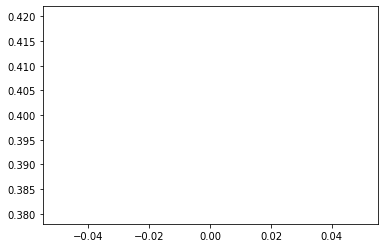

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [10]:
TEST_SAMPLE.shape

(70, 1005, 558, 3)

In [11]:
TEST_LABEL.shape

(29, 1)

In [13]:
test_loss, test_acc = model.evaluate(TRAIN_SAMPLE,  TRAIN_LABEL, verbose=2)

print(test_acc)

3/3 - 111s - loss: 0.6925 - accuracy: 0.5000
0.5
